Two qubit errors
===============

This is a simulation of qubit errors with CX gates to give confidence that the noise model in Qiskit and transpilation is working as expected.

A number of CX gates given by GATE_DEPTH are applied.  If EXTRA_X_GATE is True an additional two X gates can be applied to the first qubit between each CX gate for testing.  The gates are transpiled to the native gate set of the Ion computer.

The calculation does not show an error with the native IBM gate set.  However, it works fine with the native gate set of the ion computer.  Since we are only working with the native ion computer gate set no further action is needed.

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile

from helper_functions import (get_noise, mean_of_list, calculate_standard_error)

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

SHOTS = 10000                            #Number of shots to run 
MEASURE_NOISE = 0.00046                  #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.0           #Single gate noise not relevant   
TWO_GATE_DEPOLARISING = 0.0102           #Two gate noise 

GATE_DEPTH = 8
ITERATIONS = 25

EXTRA_X_GATE = False                     #Able to add extra X gates if needed for testing.  No longer relevant.

NOISE = True                             #Test with noise
SIMULATOR = Aer.get_backend('qasm_simulator')

The expected number of cases where both qubits are in the excited state is calculated.  

In [3]:
expected_probability = ( 1 - TWO_GATE_DEPOLARISING ) ** GATE_DEPTH * (1 - MEASURE_NOISE)
expected = expected_probability * SHOTS

The basic circuit is set up using standard gates.

In [4]:
if (GATE_DEPTH % 2) == 0:
    state = '|01>'
    state_index = '01'
else:
    state = '|11>'
    state_index = '11'

noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                        TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET)
simulated_probability_list = []

for iteration in range(ITERATIONS):
    qr = QuantumRegister(2,'code_qubit')     # Two qubits
    cr = ClassicalRegister(2,'syndrome_bit') # Two Syndrome bit
    qc = QuantumCircuit(qr,cr)
    initial_state = [0,1]   # Define initial_state as |1>
    qc.reset(qr[0])
    qc.reset(qr[1])
    qc.x(qr[0])
    for i in range(GATE_DEPTH):
        qc.cx(qr[0],qr[1])
        if EXTRA_X_GATE:
            qc.x(qr[0])
            qc.x(qr[0])
    qc.measure(qr, cr)
    qt = transpile(qc, basis_gates = BASIS_GATE_SET)
    if NOISE:
        result = execute(qt, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
    else:
        result = execute(qt, SIMULATOR, shots=SHOTS).result()   
    counts = result.get_counts(qt)
    simulated_results = counts[state_index]
    simulated_probability = simulated_results / SHOTS
    simulated_probability_list.append(simulated_probability)   
mean = mean_of_list(simulated_probability_list)
standard_deviation, standard_error = calculate_standard_error(simulated_probability_list)
print(f'With {SHOTS} shots we expect to see {expected:.0f} instances of the {state} state with probability {expected_probability:.4f}')
print()
print(f' There were {ITERATIONS} iterations')
print(f'The simulated mean is {mean:.4f}')
print(f'The standard deviation is {standard_deviation:.4f} and the standard error is {standard_error:.4f}')

With 10000 shots we expect to see 9208 instances of the |01> state with probability 0.9208

 There were 25 iterations
The simulated mean is 0.9211
The standard deviation is 0.0029 and the standard error is 0.0006


Note above that the convention used is |Qbit1 Qbit0>.

Draw circuit before transpilation

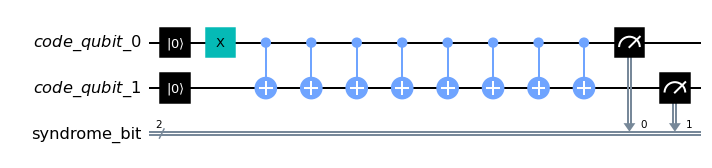

In [5]:
qc.draw(output='mpl', filename = "Basic_two_qubit_errors_circuit")

The transpiled circuit can be printed out.

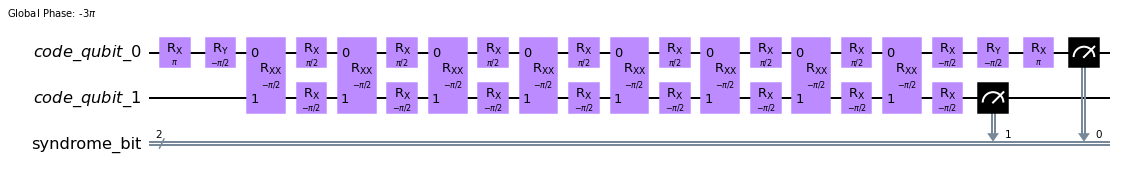

In [6]:
qt.draw(output='mpl', filename = "Basic_two_qubit_errors_transpiled_circuit")

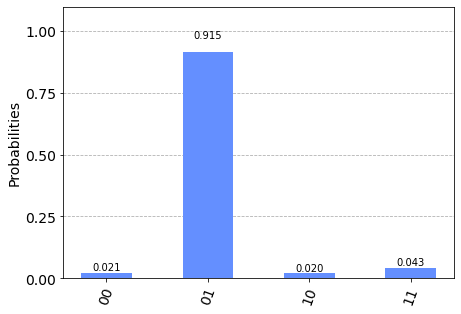

In [7]:
fname = "Basic_two_qubit_errors_histogram.png"
plot_histogram(counts).savefig(fname)
plot_histogram(counts)